## CNN LSTM Model

In [1]:
import warnings
warnings.filterwarnings('ignore')
import time
import pandas as pd
import numpy as np
from base_line_DNN import CNN_LSTM as network
from base_line_DNN import ProcessData
from base_line_LR import LR
from datetime import datetime
from tensorflow.keras.utils import plot_model

def get_timestamp():
    dateTimeObj = datetime.now()
    timestampStr = dateTimeObj.strftime("%d-%b-%Y_%H_%M_%S")
    return timestampStr

Reading Emoticons ...
Reading Slangs ...


### Load English Data

Load and format the data in the way ProcessData class is expecting the input. 

In [2]:
df_en = pd.read_csv('../data/dataset_en.csv')
df_en = df_en.dropna() # drop any rows with nans
df_en.drop(df_en.loc[df_en['text_id'] == 'text_id'].index,inplace=True)
# df_en.drop(df_en.loc[df_en['class'] == 'HS'].index,inplace=True)
df_en["class"] = df_en["class"].astype(int)
df_en['text_len'] = df_en.apply(lambda x: len(x.text.split()), axis=1)
df_en = df_en[df_en['text_len']<200]

In [3]:
df_en['class'].unique()

array([1, 0, 2])

In [4]:
## Set the paramters for the model training
parameters={'lang':'en',
       'seed':30,
       'epochs':50, 
       'batch_size':30, 
       'optimiser':'sgd', 
       'lr_rate':0.001, 
       'drop_out':0.2, 
       'hidden_size':64,
        'val_split':0.2
      }

### Convert Text Into Sequences

In [5]:
# convert text into seq
start_time = time.time()
data = ProcessData(df_en, lang=parameters['lang'])
seconds = time.time() - start_time
print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(seconds)))

Reading twitter - 1grams ...
Reading twitter - 2grams ...


  0%|          | 100/50369 [00:00<00:50, 997.02it/s]

Reading twitter - 1grams ...


100%|██████████| 50369/50369 [00:34<00:00, 1449.00it/s]


Time Taken: 00:00:41


In [6]:
print(data.max_seq_len, data.vocab_size, data.classes)

138 23051 [2 1 0]


### Build CNN LSTM Network

In [7]:
net = network(param=parameters)
model = net.get_model_2(classes=len(data.classes), 
                        vocabulary_size=data.vocab_size, 
                        input_length=data.max_seq_len, 
                        param=parameters)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 138)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 138, 100)     2305100     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 138, 100, 1)  0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)      

In [10]:
plot_model(model, to_file='model.png')

In [8]:
tmp = get_timestamp()
start_time = time.time()
model_path = '../model/'+tmp+'_en_weights.best.hdf5'
hist = net.train(data.X_train, data.y_train, model, model_path, data.class_weight)
seconds = time.time() - start_time
print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(seconds)))

Train on 32236 samples, validate on 8059 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
32160/32236 [============================>.] - ETA: 0s - loss: 1.0444 - acc: 0.4546
Epoch 00001: val_acc improved from -inf to 0.50850, saving model to ../model/02-Sep-2020_01_43_23_en_weights.best.hdf5
32236/32236 [==============================] - 22s 698us/sample - loss: 1.0446 - acc: 0.4543 - val_loss: 0.9913 - val_acc: 0.5085
Epoch 2/50
32130/32236 [============================>.] - ETA: 0s - loss: 0.9627 - acc: 0.5489
Epoch 00002: val_acc improved from 0.50850 to 0.58580, saving model to ../model/02-Sep-2020_01_43_23_en_weights.best.hdf5
32236/32236 [==============================] - 18s 563us/sample - loss: 0.9625 - acc: 0.5493 - val_loss: 0.9290 - val_acc: 0.5858
Epoch 3/50
32190/32236 [============================>.] - ETA: 0s - loss: 0.9082 - acc: 0.5924
Epoch 00003: val_acc improved from 0.58580 to 0.60169, saving model to ../model/02-Sep-2020_01_43_23_en_weights.best.

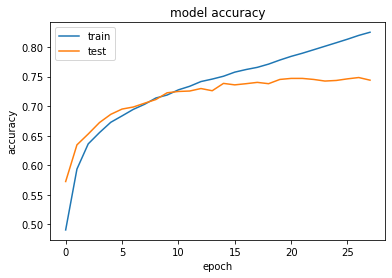

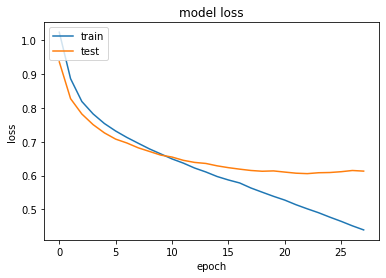

In [8]:
# hist.history.keys()
net.plot_taining_graphs(hist)

In [9]:
test_loss, test_acc = net.test(model,data.X_test, data.y_test)

print("Overall Accuracy:", test_acc)
print("Overall Loss:", test_loss)

10074/10074 [==============================] - 2s 158us/sample - loss: 0.8956 - acc: 0.7896
Overall Accuracy: 0.78964064
Overall Loss: 0.3956158276006109


In [8]:
y_pred = model.predict(data.X_test)

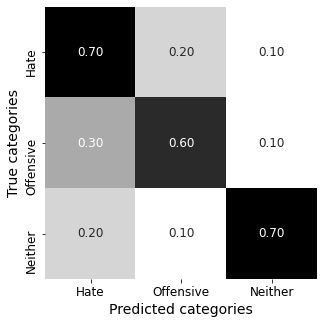

In [6]:
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(data.y_test, axis=1)
cls_obj = LR()
cls_obj.gen_confusion_matrix(y_test = y_test, y_pred = y_pred, classes = 3)

From above confusion matrix, we see that the model clearly identifies, Neither class but has issues with offensive and hate class

In [13]:
print(cls_obj.gen_report(y_test, y_pred)[1])

              precision    recall  f1-score   support

           0       0.76      0.82      0.74      3386
           1       0.63      0.69      0.63      2157
           2       0.78      0.71      0.72      4531

    accuracy                           0.77     10074
   macro avg       0.78      0.76      0.76     10074
weighted avg       0.76      0.77      0.76     10074



In [16]:
parameters['epochs']=len(hist.history['acc'])
parameters['test_acc']=test_acc
parameters['test_loss']=test_loss
parameters['timestamp']=tmp
df = pd.DataFrame([parameters])
df.to_csv('result.csv', mode='a', index=False)

### Load Hindi Dataset

In [8]:
df_hi = pd.read_csv('../data/dataset_hi.csv')
df_hi["class"] = df_hi["class"].astype(int)
df_hi = df_hi.dropna() # drop any rotokenizer_testws with nans
df_hi.drop(df_hi.loc[df_hi['text_id'] == 'text_id'].index,inplace=True)
df_hi.drop(df_hi.loc[df_hi['class'] == 'HS'].index,inplace=True)
df_hi['text_len'] = df_hi.apply(lambda x: len(x.text.split()), axis=1)
df_hi = df_hi[df_hi['text_len']<200]

### Convert Text Into Sequences

In [9]:
start_time = time.time()
data = ProcessData(df_hi, lang='hi')
seconds = time.time() - start_time
print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(seconds)))

Reading english - 1grams ...


100%|██████████| 9330/9330 [24:11<00:00,  6.43it/s]


Time Taken: 00:24:13


In [10]:
data.max_seq_len, data.vocab_size, data.classes

(104, 6075, array([0, 1]))

In [11]:
# set model parameters
parameters={'lang':'hi',
       'seed':30,
       'epochs':20, 
       'batch_size':30, 
       'optimiser':'sgd', 
       'lr_rate':0.001, 
       'drop_out':0.1, 
       'hidden_size':32,
            'val_split':0.2
      }

### Build CNN LSTM model

In [12]:
net = network(param=parameters)
model = net.get_model_2(classes=len(data.classes), 
                        vocabulary_size=data.vocab_size, 
                        input_length=data.max_seq_len,
                        param=parameters)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 104)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 104, 100)     607500      input_2[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 104, 100, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 102, 1, 64)   19264       reshape_2[0][0]                  
__________________________________________________________________________________________________
conv2d_4 (

In [13]:
tmp=get_timestamp()
start_time = time.time()
model_path = '../model/'+tmp+'_hi_weights.best.hdf5'
hist = net.train(data.X_train, data.y_train, model, model_path, data.class_weight)
seconds = time.time() - start_time
print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(seconds)))

Train on 5971 samples, validate on 1493 samples
Epoch 1/20
5910/5971 [============================>.] - ETA: 0s - loss: 0.7049 - acc: 0.5191
Epoch 00001: val_acc improved from -inf to 0.55325, saving model to ../model/28-Aug-2020_20_03_22_hi_weights.best.hdf5
5971/5971 [==============================] - 8s 1ms/sample - loss: 0.7045 - acc: 0.5193 - val_loss: 0.6923 - val_acc: 0.5532
Epoch 2/20
5970/5971 [============================>.] - ETA: 0s - loss: 0.6847 - acc: 0.5476
Epoch 00002: val_acc improved from 0.55325 to 0.57803, saving model to ../model/28-Aug-2020_20_03_22_hi_weights.best.hdf5
5971/5971 [==============================] - 3s 482us/sample - loss: 0.6847 - acc: 0.5476 - val_loss: 0.6895 - val_acc: 0.5780
Epoch 3/20
5970/5971 [============================>.] - ETA: 0s - loss: 0.6772 - acc: 0.5695
Epoch 00003: val_acc improved from 0.57803 to 0.59946, saving model to ../model/28-Aug-2020_20_03_22_hi_weights.best.hdf5
5971/5971 [==============================] - 3s 528us/samp

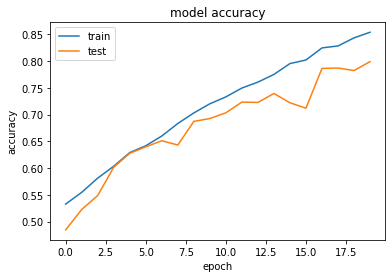

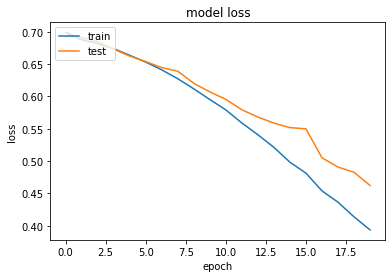

In [96]:
net.plot_taining_graphs(hist)

In [97]:
test_loss, test_acc = net.test(model,data.X_test, data.y_test)

print("Overall Accuracy:", test_acc)
print("Overall Loss:", test_loss)

1866/1866 [==============================] - 2s 944us/sample - loss: 0.6862 - acc: 0.5975
Overall Accuracy: 0.85753484
Overall Loss: 0.4262238354238284


In [20]:
y_pred = model.predict(data.X_test)

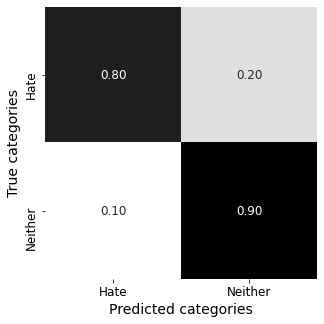

In [10]:
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(data.y_test, axis=1)
cls_obj = LR()
cls_obj.gen_confusion_matrix(y_test = y_test, y_pred = y_pred, classes = 2)

The Hindi model perfectly identifies both Hate and non hate classes

In [21]:
print(cls_obj.gen_report(y_test, y_pred)[1])

              precision    recall  f1-score   support

           0       0.84      0.80      0.86       893
           1       0.88      0.90      0.86       973

    accuracy                           0.86      1866
   macro avg       0.87      0.85      0.86      1866
weighted avg       0.86      0.87      0.86      1866



In [17]:
parameters['epochs']=len(hist.history['acc'])
parameters['test_acc']=test_acc
parameters['test_loss']=test_loss
parameters['timestamp']=tmp
df = pd.DataFrame([parameters])
df.to_csv('result.csv', mode='a', index=False, header=False)

### Load Hi-Code Mix dataset

In [14]:
df_hi_cdmx = pd.read_csv('../data/dataset_hi_cdmx.csv')
df_hi_cdmx["class"] = df_hi_cdmx["class"].astype(int)
df_hi_cdmx = df_hi_cdmx.dropna() # drop any rotokenizer_testws with nans
df_hi_cdmx = df_hi_cdmx.drop(['text'],axis=1)
df_hi_cdmx = df_hi_cdmx.rename(columns={'basic_clean_text':'text'})
print(df_hi_cdmx.columns)
df_hi_cdmx.drop(df_hi_cdmx.loc[df_hi_cdmx['text_id'] == 'text_id'].index,inplace=True)
df_hi_cdmx.drop(df_hi_cdmx.loc[df_hi_cdmx['class'] == 'HS'].index,inplace=True)
df_hi_cdmx['text_len'] = df_hi_cdmx.apply(lambda x: len(x.text.split()), axis=1)
df_hi_cdmx = df_hi_cdmx[df_hi_cdmx['text_len']<200]

Index(['class', 'text_id', 'ekphrasis_clean_text', 'text'], dtype='object')


### Convert Text into Sequences

In [15]:
start_time = time.time()
data = ProcessData(df_hi_cdmx, lang='en')
seconds = time.time() - start_time
print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(seconds)))

Reading twitter - 1grams ...
Reading twitter - 2grams ...


  6%|▌         | 197/3161 [00:00<00:01, 1967.05it/s]

Reading twitter - 1grams ...


100%|██████████| 3161/3161 [00:01<00:00, 1960.58it/s]


Time Taken: 00:00:06


In [16]:
data.max_seq_len, data.vocab_size, data.classes

(105, 6018, array([2, 0, 1]))

In [17]:
# set model Parameters
parameters={'lang':'en',
       'seed':30,
       'epochs':50, 
       'batch_size':30, 
       'optimiser':'adam', 
       'lr_rate':0.01, 
       'drop_out':0.2, 
       'hidden_size':64,
            'val_split':0.2
      }

### Build Model for code-mix Hindi

In [18]:
net = network(param=parameters)
model = net.get_model_2(classes=len(data.classes),
                        vocabulary_size=data.vocab_size,
                        input_length=data.max_seq_len,
                        param=parameters)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 105)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 105, 100)     601800      input_3[0][0]                    
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 105, 100, 1)  0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 103, 1, 64)   19264       reshape_4[0][0]                  
__________________________________________________________________________________________________
conv2d_7 (

In [19]:
tmp=get_timestamp()
start_time = time.time()
model_path = '../model/'+tmp+'hi_cdmx_weights.best.hdf5'
hist = net.train(data.X_train, data.y_train, model, model_path, data.class_weight)
seconds = time.time() - start_time
print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(seconds)))

Train on 2022 samples, validate on 506 samples
Epoch 1/50
1920/2022 [===========================>..] - ETA: 0s - loss: 1.0872 - acc: 0.3943
Epoch 00001: val_acc improved from -inf to 0.47233, saving model to ../model/28-Aug-2020_20_04_38hi_cdmx_weights.best.hdf5
2022/2022 [==============================] - 8s 4ms/sample - loss: 1.0841 - acc: 0.3961 - val_loss: 1.0935 - val_acc: 0.4723
Epoch 2/50
2010/2022 [============================>.] - ETA: 0s - loss: 0.9829 - acc: 0.5557
Epoch 00002: val_acc improved from 0.47233 to 0.65415, saving model to ../model/28-Aug-2020_20_04_38hi_cdmx_weights.best.hdf5
2022/2022 [==============================] - 1s 593us/sample - loss: 0.9825 - acc: 0.5569 - val_loss: 1.0840 - val_acc: 0.6542
Epoch 3/50
2010/2022 [============================>.] - ETA: 0s - loss: 0.8784 - acc: 0.6279
Epoch 00003: val_acc improved from 0.65415 to 0.66008, saving model to ../model/28-Aug-2020_20_04_38hi_cdmx_weights.best.hdf5
2022/2022 [==============================] - 1s

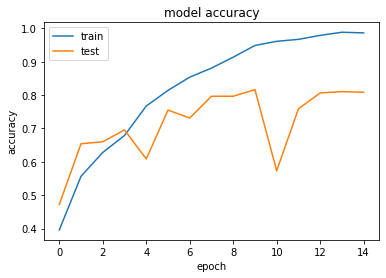

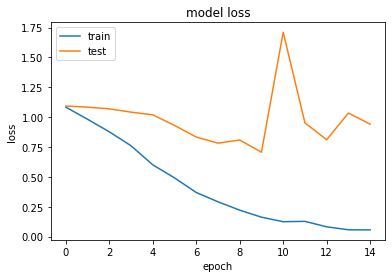

In [20]:
net.plot_taining_graphs(hist)

In [22]:
test_loss, test_acc = net.test(model,data.X_test, data.y_test)

print("Overall Accuracy:", test_acc)
print("Overall Loss:", test_loss)

633/633 [==============================] - 0s 220us/sample - loss: 1.0032 - acc: 0.5624
Overall Accuracy: 0.86240124
Overall Loss: 0.3031736399890123


In [30]:
y_pred = model.predict(data.X_test)

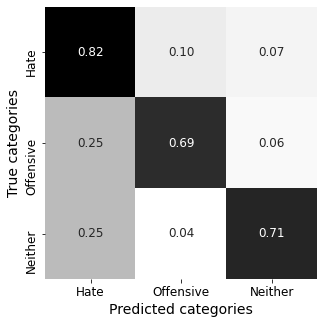

In [18]:
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(data.y_test, axis=1)
cls_obj = LR()
cls_obj.gen_confusion_matrix(y_test = y_test, y_pred = y_pred, classes = 3)

In [31]:
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(data.y_test, axis=1)
cls_obj = LR()
print(cls_obj.gen_report(y_test, y_pred)[1])

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       231
           1       0.62      0.69      0.62        60
           2       0.73      0.71      0.70       342

    accuracy                           0.79       633
   macro avg       0.83      0.85      0.83       633
weighted avg       0.85      0.82      0.85       633



In [19]:
parameters['epochs']=len(hist.history['acc'])
parameters['test_acc']=test_acc
parameters['test_loss']=test_loss
parameters['timestamp']=tmp
df = pd.DataFrame([parameters])
df.to_csv('result.csv', mode='a', index=False)

## Test Case

Testing model for single instance sample

In [4]:
start_time = time.time()
text = ['@AvijitEmmi Bahenchod .... experienced lagte ho bhai bhot face with tears of joy']
test_data = ProcessData(df=text, lang='en', max_seq_len=48)
net = network(param=parameters)
out = net.predict(model_path='../model/23-Aug-2020_18_08_51_hi_cdmx_weights.best.hdf5',x=test_data.X)
seconds = time.time() - start_time
print(out)
print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(seconds)))

Reading twitter - 1grams ...
Reading twitter - 2grams ...


100%|██████████| 1/1 [00:00<00:00, 1277.97it/s]

Reading twitter - 1grams ...
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
[array([2]), array([[0.003038, 0.012554, 0.018429]], dtype=float32)]
Time Taken: 00:00:13


In [6]:
start_time = time.time()
text = ["A gangster sets out to fulfill his father’s dream of becoming a doctor.    Doctor's in #WestBengal be like #munna_bhai_MBBS    #DoctorsFightBack #DoctorsStrike #DoctorsUnderOppression   @MamataOfficial https://t.co/lZQcStQ2Md"]
test_data = ProcessData(df=text, lang='en', max_seq_len=89)
net = network(param=parameters)
out = net.predict(model_path='../model/28-Aug-2020_19_32_42_en_weights.best.hdf5',x=test_data.X)
seconds = time.time() - start_time
print(out)
print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(seconds)))

Reading twitter - 1grams ...
Reading twitter - 2grams ...


100%|██████████| 1/1 [00:00<00:00, 501.47it/s]

Reading twitter - 1grams ...


[array([1]), array([[0.005687, 0.03995 , 0.015902]], dtype=float32)]
Time Taken: 00:00:14


In [8]:
start_time = time.time()
text = ["ये लिटन की गाँड में लिप्टन की चाय डालता हूँ अभी विथ गर्म केतली"]
test_data = ProcessData(df=text, lang='hi', max_seq_len=104)
net = network(param=parameters)
out = net.predict(model_path='../model/28-Aug-2020_20_03_22_hi_weights.best.hdf5',x=test_data.X)
seconds = time.time() - start_time
print(out)
print('Time Taken:', time.strftime("%H:%M:%S",time.gmtime(seconds)))

Reading english - 1grams ...


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


[array([0]), array([[0.096223, 0.024478]], dtype=float32)]
Time Taken: 00:00:13
